The goal of this notebook is to make `train_emulator()` iterate thru all parameters for each variable and save those predictions using pickle

- i think making a file for each {var}_{param_index}
- Using these objects as inputs for information to call in both plotting functions
- Removing iteration clauses from plotting function



To aid in plotting functions:

Once this is running, do it for all 10 clim. vars. 

Then create a chunk to iterate through the min, max in each pred-clim. var/param relationship and use that to set the boundaries on the plotting.
Would be super optimal if this was fast enough to have included in back end of dashboard, so when new vars are called, it will provide the correct bounds for plots

- ylim to assess the min, max in each pred-clim. var/param relationship

Author: Sofia Ingersoll

Date: 2024 May 17 

In [1]:
import xarray as xr
import pickle
from utils import * 

# Request an additional 10 cores of power for processing from the server
client = get_cluster("UCSB0021", cores = 30)
# apply peer2peer network communication across multiple devices
client.cluster

Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/singersoll/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.86:34649,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/singersoll/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
param, var, param_name, var_name = read_n_wrangle("leafcn", "LNC")

In [14]:
param.shape

(500, 32)

In [15]:
var.shape

(500,)

In [36]:
def create_parameter_names_dict():
    data = {
        key.upper(): value for key, value in {
            'FUN_fracfixers': 0, 'KCN': 1, 'a_fix': 2, 'crit_dayl': 3, 'd_max': 4, 'fff': 5,
            'froot_leaf': 6, 'fstor2tran': 7, 'grperc': 8, 'jmaxb0': 9, 'jmaxb1': 10, 'kcha': 11,
            'kmax': 12, 'krmax': 13, 'leaf_long': 14, 'leafcn': 15, 'lmr_intercept_atkin': 16,
            'lmrha': 17, 'lmrhd': 18, 'medlynintercept': 19, 'medlynslope': 20, 'nstem': 21,
            'psi50': 22, 'q10_mr': 23, 'slatop': 24, 'soilpsi_off': 25, 'stem_leaf': 26,
            'sucsat_sf': 27, 'theta_cj': 28, 'tpu25ratio': 29, 'tpuse_sf': 30, 'wc2wjb0': 31
        }.items()
    }
    return data
    
# object to store in utils outside of any function so it's callable
param_names_dict = create_parameter_names_dict()

In [73]:
def train_emulator(param, var, param_name, var_name):
    #param_names_dict = create_parameter_names_dict()

    # Split Data 90/10
    X_train, X_test, y_train, y_test = train_test_split(param, var, test_size=0.2, random_state=0)

    # Kernel Specs No Tuning
    kernel = ConstantKernel(constant_value=3, constant_value_bounds=(1e-2, 1e4)) * RBF(length_scale=1, length_scale_bounds=(1e-4, 1e8))

    # Using an out-of-the-box kernel for now
    gpr_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20, random_state=99, normalize_y=True)

    # Fit the model to the training data
    gpr_model.fit(X_train, y_train)

    # Iterate through all parameters and make predictions for each
    for param_index, param_name in param_names_dict.items():
        # Create X_values for prediction linspace
        X_values = np.full((100, 32), 0.5)
        X_values[:, param_name] = np.linspace(0, 1, 100)

        # Make predictions for the current parameter
        y_pred, y_std = gpr_model.predict(X_values, return_std=True)

        # Collect Metrics
        mae = mean_absolute_error(y_test, y_pred)
        rmse_emulator = np.sqrt(mean_squared_error(y_test, y_pred))
        r2_emulator = np.corrcoef(y_test, y_pred)[0, 1]**2

        # Save the predictions and overall R^2 to a file
       # filename = os.path.join("emulation_results", f"{var_name}_{list(param_names_dict.keys())[param_index]}_gpr_model.sav")
        filename = os.path.join("emulation_results", f"{var_name}_{param_names_dict[param_index]}_gpr_model.sav")


       # filename = os.path.join("emulation_results", f"{var_name}_{list(param_names_dict.keys())[int(param_index)]}_gpr_model.sav")

        if os.path.exists(filename):
            # Load the model from disk
            loaded_model = pickle.load(open(filename, 'rb'))
        else:
            print("Emulator is running, this may take a few moments")

        with open(filename, 'wb') as file:
            pickle.dump((X_values, y_pred, y_std, r2_emulator, param_name, var_name), file)

    sorted_indices = np.argsort(r2_emulator)
    sorted_parameter_emulations = np.array([y_pred[:100], y_test])[sorted_indices]
    sorted_parameter_names = [param_name for param_name, _ in sorted(param_names_dict.items(), key=lambda x: x[1])]

    return y_pred, y_std, y_test, X_test, r2_emulator

In [77]:
def train_emulator(param, var, param_name, var_name):
    # Split Data 90/10
    X_train, X_test, y_train, y_test = train_test_split(param, var, test_size=0.2, random_state=0)

    # Kernel Specs No Tuning
    kernel = ConstantKernel(constant_value=3, constant_value_bounds=(1e-2, 1e4)) * RBF(length_scale=1, length_scale_bounds=(1e-4, 1e8))

    # Using an out-of-the-box kernel for now
    gpr_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20, random_state=99, normalize_y=True)

    # Fit the model to the training data
    gpr_model.fit(X_train, y_train)

    # Iterate through all parameters and make predictions for each
    for param_index, param_name in param_names_dict.items():
        # Create X_values for prediction linspace
        X_values = np.full((100, 32), 0.5)
        X_values[:, param_name] = np.linspace(0, 1, 100)

        # Make predictions for the current parameter
        y_pred, y_std = gpr_model.predict(X_values, return_std=True)

        # Collect Metrics
        mae = mean_absolute_error(y_test, y_pred)
        rmse_emulator = np.sqrt(mean_squared_error(y_test, y_pred))
        r2_emulator = np.corrcoef(y_test, y_pred)[0, 1]**2

        # Save the predictions and overall R^2 to a file
        filename = os.path.join("emulation_results", f"{var_name}_{param_names_dict[param_index]}_gpr_model.sav")

        if os.path.exists(filename):
            # Load the model from disk
            loaded_model = pickle.load(open(filename, 'rb'))
        else:
            print("Emulator is running, this may take a few moments")

        with open(filename, 'wb') as file:
            pickle.dump((X_values, y_pred, y_std, r2_emulator, param_name, var_name), file)

    sorted_indices = np.argsort(r2_emulator)
    sorted_parameter_emulations = np.array([y_pred[:100], y_test])[sorted_indices]
    sorted_parameter_names = [param_name for param_name, _ in sorted(param_names_dict.items(), key=lambda x: x[1])]

    return y_pred, y_std, y_test, X_test, r2_emulator

In [79]:
# the way the models keep reloading indicated we're not pickling properly
y_pred, y_std, y_test, X_test, r2_emulator = train_emulator(param, var, param_name, var_name)

In [84]:
# picking out leafcn because the expected r^2 is 0.94
with open("emulation_results/LNC_15_gpr_model.sav", 'rb') as file:
    X_values, y_pred, y_std, r2_emulator, param_name, var_name = pickle.load(file)

In [85]:
r2_emulator

0.007631194629843736

In [51]:
def plot_emulator(var_name, param_name, param_names_dict):
    # Load the pickled prediction data for the selected parameter 
    filename = os.path.join("emulation_results", f"{var_name}_{param_names_dict[param_name.upper()]}_gpr_model.sav")
   
    with open(filename, 'rb') as file:
        X_values, y_pred, y_std, r2_emulator = pickle.load(file)

    # Get the parameter name corresponding to the index
    indexed_param = param_names_dict[param_name.upper()]

    # Calculate the z-score for the 99.7% confidence interval
    z_score = norm.ppf(0.99865)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(X_values[:, indexed_param],
             y_pred,
             color='#134611',
             label='GPR Prediction')

    plt.text(0.5, np.max(y_pred),
             f'R² Score = {r2_emulator:.2f}',
             fontsize=10)

    # Apply z-score for 99.7% CI
    plt.fill_between(X_values[:, indexed_param],
                     y_pred - z_score * y_std, y_pred + z_score * y_std,
                     alpha=0.5,
                     color='#9d6b53',
                     label='3 St.Dev., Confidence Interval')

    plt.xlabel(f'Perturbed Parameter: {param_name.title()}')
    plt.ylabel(f'Variable: {var_name.split("_")[0].title()}')
    plt.title('Parameter Perturbation Uncertainty Estimation')
    plt.legend()

    # Save the plot as a PNG file
    plt.savefig(f'plots/emulator/emulator_plot_{var_name}_{param_name}.png')

    plt.show()


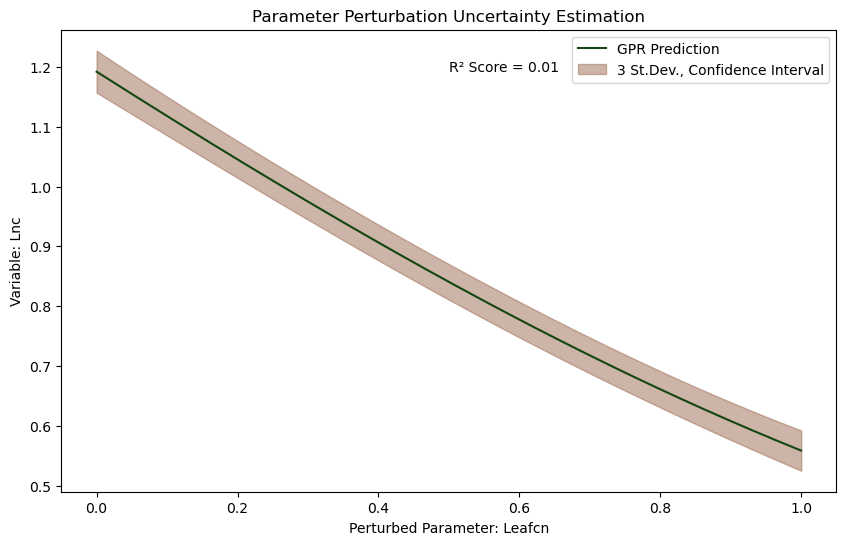

In [52]:
plot_emulator(var_name, param_name, param_names_dict)